# Load modules

In [1]:
import sys
import time

from functools import partial
from tqdm.auto import tqdm
sys.path.append('../code/')
import source
import importlib
importlib.reload(source)
from source.map_params import beam_size_fwhm
from source.cosmology import LambdaCDMCosmo
from source.catalog import CatalogASCII
from source.skymap import PlanckMap
from source import map_params
import healpy as hp
import numpy as np
import numpy.ma as ma
import astropy.units as au

import matplotlib
matplotlib.style.use('Minh_paper_style')
import matplotlib.pyplot as plt
from matplotlib.ticker import (FixedLocator, MultipleLocator, FixedFormatter, FormatStrFormatter,
                               AutoMinorLocator)

# Load simulated instrumental noise maps

In [2]:
map_path = '../data/cmb/simulated_map/noise/dx12_v3_smica_noise_mc_0000'
mask_filename = '../data/cmb/survey_mask/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits' # common mask
extra_mask_name = '../data/cmb/survey_mask/COM_CompMap_Compton-SZMap-PSmask_2048_R2.01.fits' # Planck y-map PS mask
map_nr=4
map_list = []
for i in tqdm(range(map_nr), total=map_nr):
    map_filename = map_path + str(i) + '_raw.fits'
    single_map = PlanckMap(mapFile=map_filename,maskFile=mask_filename,map_coord='G')
    single_map.combine_mask(extra_mask_name)
    map_list.append(single_map)

  0%|          | 0/4 [00:00<?, ?it/s]

Map unit changed from K to muK
Map unit changed from K to muK
Map unit changed from K to muK
Map unit changed from K to muK


# Load clusters and apply a cut based on percentage of masked pixels

In [3]:
## Load clusters (see the "select_cluster" notebook for further details)

catFile='../data/cluster/maxBCG_ID_redshift_sky_selected.dat'
cat = CatalogASCII(catFile,use_photoz=False,specz_col=3,N200_col=4)

ID = cat.id
z = cat.specz
ra = cat.coord.ra
dec = cat.coord.dec
N200 = cat.N200
N_cluster = len(N200)
print("Total number of clusters loaded:")
print(N_cluster)

## Check how many clusters should be removed due to masked pixels

size = map_params.patch_size
n_pixels=int(map_params.n_pixels)
patches=[]
removed=[]

for i in tqdm(range(len(ra)), total=len(ra)):
    patch = map_list[0].get_Cartesian_square_patch(ra[i],dec[i],
                    patch_size=size,
                    n_pixels=n_pixels,
                    return_proj=False)
    if ((np.isclose(patch,hp.UNSEEN)).sum()/len(patch.ravel())<=0.2):
        patch[np.isclose(patch,hp.UNSEEN)]=0.
        patches.append(patch)
    else:
        removed.append(ID[i])
        
np.savetxt("../data/cluster/masking_removal_ID.txt",removed)

## Actually remove these clusters

masked_pixel_cut = np.in1d(ID, removed, invert=True)
ID = ID[masked_pixel_cut]
z = z[masked_pixel_cut]
ra = ra[masked_pixel_cut]
dec = dec[masked_pixel_cut]
N200 = N200[masked_pixel_cut]

Total number of clusters loaded:
2189


  0%|          | 0/2189 [00:00<?, ?it/s]

# Project out square patches only for final selected clusters

In [5]:
## In this tutorial, which will be run on a single machine, we use multiprocessing for parallelization
## To actually scale it up on multiple nodes on a cluster, one can use either dask or ray

import multiprocessing

def process_single_map(ra, dec, single_map):
    patch = [single_map.get_Cartesian_square_patch(ra_i, dec_i,
                    patch_size=size,
                    n_pixels=n_pixels,
                    return_proj=False) for ra_i,dec_i in zip(ra, dec)]
    return patch

nr_core=4
pool = multiprocessing.Pool(int(2*nr_core))
patches = pool.map(partial(process_single_map, ra, dec), map_list)
patches = np.asarray(patches)

NameError: name 'masked_patches' is not defined

In [ ]:
masked_patches = ma.masked_where(patches==hp.UNSEEN, masked_patches)
print(masked_patches)

# Plot example patches

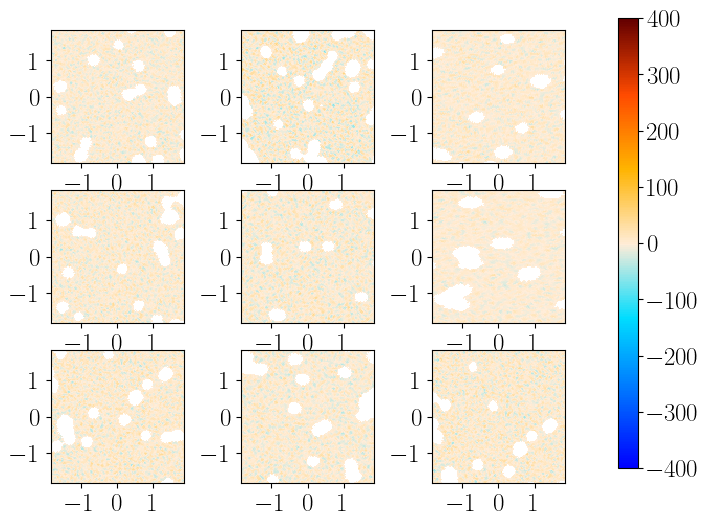

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=3,dpi=100)
for i, ax in enumerate(axes.flat):
    im=ax.imshow(patches[0,i,:,:],origin='lower',interpolation='None',cmap=map_list[0].cmap,extent=[-size.to_value(au.deg)/2., size.to_value(au.deg)/2., -size.to_value(au.deg)/2., size.to_value(au.deg)/2.],vmin=-400.,vmax=400.)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.75])
fig.colorbar(im, cax=cbar_ax)
#cbar_ax.set_label("$\Delta T\,[\mu K]$", rotation=-90, va="bottom")
plt.show()

# Estimate instrumental noise per each pixel, and then average within a patch

(2053, 128, 128)


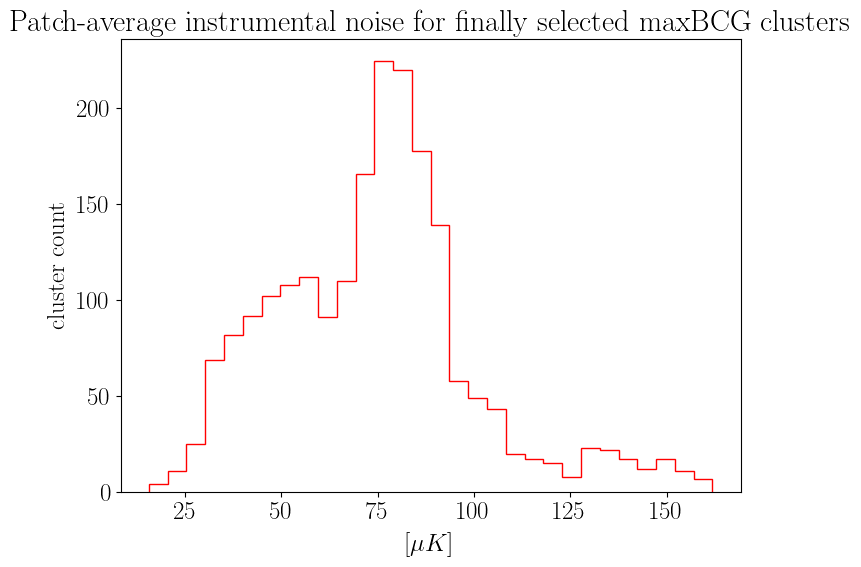

In [40]:
sigma2pix_est = patches.var(axis=0)
print(sigma2pix_est.shape)
sigma2pix_patch_avg_est = sigma2pix_est.mean(axis=(1,2))

fig, ax = plt.subplots()
_ = plt.hist(sigma2pix_patch_avg_est,bins='auto', histtype='step', color='red')
ax.set_title('Patch-average instrumental noise for finally selected maxBCG clusters')
ax.set_ylabel('cluster count')
ax.set_xlabel('[$\mu K$]')
plt.show()

# Plot some levels of instrumental noise power spectra vs. CMB

(4, 8891)


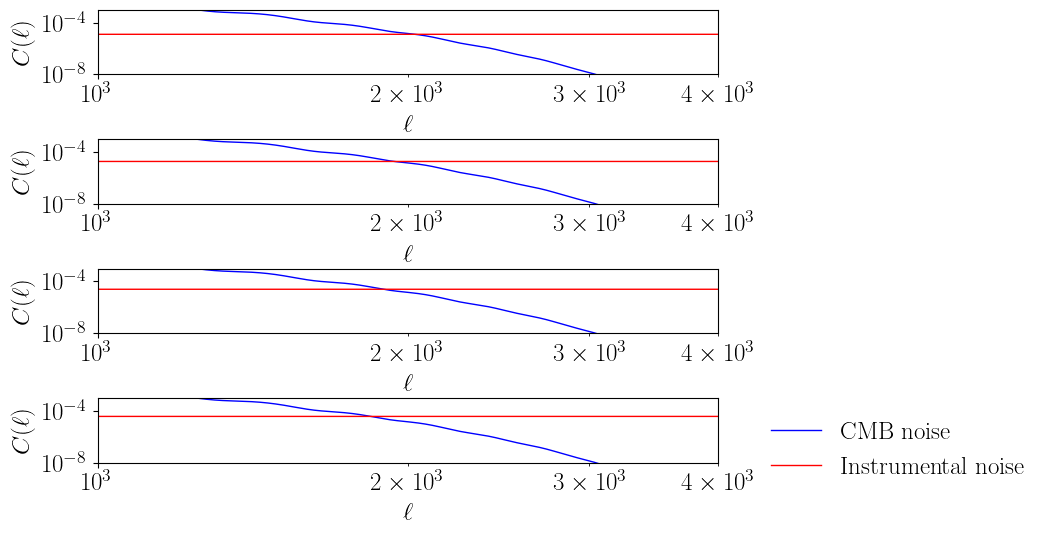

In [55]:
## Get CMB noise power

cosmo = LambdaCDMCosmo()
cosmo.get_Cl()
l=np.arange(len(cosmo.CMBpower))
Bl = hp.gauss_beam(beam_size_fwhm.to_value(au.rad), lmax=camb_lmax_out)
CMBnoise_Cl = (Bl**2)*cosmo.CMBpower
#CMBnoise_Dl = CMBnoise_Cl*l*(l+1) / (2.*np.pi)

## Get Instrumental noise power - using white noise approximation

sigma2_Nl = np.array([50,75,100,150])
INSnoise_Nl = np.einsum('i,j->ji',np.ones_like(cosmo.CMBpower), sigma2_Nl*((4.*np.pi)/hp.nside2npix(nside=map_list[0].nside)))
#INSnoise_Dl = INSnoise_Nl*l*(l+1) / (2.*np.pi)
print(INSnoise_Nl.shape)
fig, axes = plt.subplots(nrows=4, ncols=1,dpi=100)
for i, ax in enumerate(axes.flat):
    ax.loglog(l[20:],CMBnoise_Cl[20:],c='b', label='CMB noise')
    ax.loglog(l[20:],INSnoise_Nl[i,20:],c='r', label='Instrumental noise')
    ax.set_xlim(1000,4000)
    ax.set_ylim(1E-8,1E-3)
    ax.set_ylabel(r'$C(\ell)$')
    ax.set_xlabel(r'$\ell$')
fig.subplots_adjust(hspace=1.)
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [59]:
np.where(patches[0,0,:,:]==hp.UNSEEN)

(array([  0,   0,   0, ..., 127, 127, 127]),
 array([ 27,  77,  78, ..., 115, 116, 117]))